<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MVPCorrelation" data-toc-modified-id="MVPCorrelation-1">MVPCorrelation</a></span></li><li><span><a href="#Create-simulated-dataset" data-toc-modified-id="Create-simulated-dataset-2">Create simulated dataset</a></span></li><li><span><a href="#Load-post-processed-simulated-data" data-toc-modified-id="Load-post-processed-simulated-data-3">Load post-processed simulated data</a></span></li><li><span><a href="#Visualize-our-data" data-toc-modified-id="Visualize-our-data-4">Visualize our data</a></span></li></ul></div>

# MVPCorrelation

# Create simulated dataset

In [6]:
## Code for simulating the data: ##
import pymc3 as pm
np.random.seed(1)
num_subjects = 20
num_conditions = 2
num_blocks = 40
num_voxels = 50
data=[]

activations=np.full(num_subjects*num_blocks*num_voxels,np.nan)
sub_id=np.full(num_subjects*num_blocks*num_voxels,np.nan)
cond=np.full(num_subjects*num_blocks*num_voxels,"genree")
block_id=np.full(num_subjects*num_blocks*num_voxels,np.nan)
vox_id=np.full(num_subjects*num_blocks*num_voxels,np.nan)
actor=np.full(num_subjects*num_blocks*num_voxels,"namename")

from scipy import signal
def make_noncirc_gaussian_iter(mu,sd,stim_max=360):
    if np.isscalar(mu):
        mu=[mu]
    if np.isscalar(sd):
        sd=[sd]
    return np.array([sp.stats.norm.pdf(np.arange(stim_max), m, s)
                         for m,s in zip(mu,sd)]).T

# create voxel tuning functions per condition
vox_tuning = np.full((num_voxels,5),np.nan)
for v in range(num_voxels):
    vox_tuning[v,:] = make_noncirc_gaussian_iter([.5+np.random.rand()/2],[np.random.rand()+1],5).flatten()

cnt=0
conds=np.concatenate([np.repeat("comedy",num_blocks//2),np.repeat("horror",num_blocks//2)])
actors=np.tile(["Aniston","Aniston","Depp","Depp"],num_blocks//4)
for s in range(num_subjects):
    Arand=np.random.rand()
    Brand=np.random.rand()
    for r in range(num_blocks):
        c=conds[r]
        cc=actors[r]
        if c=="comedy":
            for v in range(num_voxels):
                if cc=="Aniston":
                    activations[cnt]=vox_tuning[v,1]+Arand+np.random.rand()/2
                else:
                    activations[cnt]=vox_tuning[v,1]+Brand+np.random.rand()/2
                vox_id[cnt]=v
                sub_id[cnt]=s
                actor[cnt]=cc
                cond[cnt]=c
                block_id[cnt]=r
                cnt+=1
        else:
            for v in range(num_voxels):
                if cc=="Aniston":
                    activations[cnt]=vox_tuning[v,np.random.randint(5)]+Arand+np.random.rand()/2
                else:
                    activations[cnt]=vox_tuning[v,np.random.randint(5)]+Brand+np.random.rand()/2
                vox_id[cnt]=v
                sub_id[cnt]=s
                actor[cnt]=cc
                cond[cnt]=c
                block_id[cnt]=r
                cnt+=1

np.save('activations.npy',activations)
np.save('sub_id.npy',sub_id)
np.save('cond.npy',cond)
np.save('actor.npy',actor)
np.save('block_id.npy',block_id)
np.save('vox_id.npy',vox_id)

# Load post-processed simulated data
Import our data. Look at how many subjects, trial conditions, and voxels we have to work with. 

Note that we follow Python conventions by numbering variables starting at 0 and not 1.

In [3]:
# general packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# pull data from GitHub
import requests, io
for array in ['activations','sub_id','cond','block_id','vox_id','actor']:
    globals()['{}'.format(array)] = np.load(io.BytesIO(requests.get(
        'http://paulscotti.github.io/navigateFMRI/methods/mvpa/rsa/{}.npy'.format(array)).content))

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [7]:
# change default plotting
plt.rcParams.update({'font.size': 20, 'figure.figsize': (7,2)})

# Visualize our data

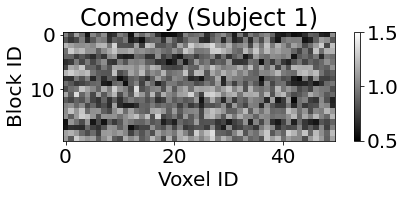

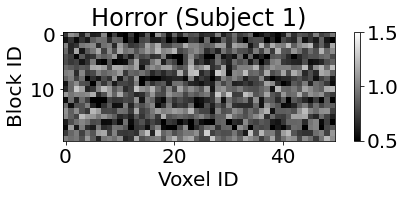

In [8]:
plt.imshow(activations[(sub_id==0)&(cond=='comedy')].reshape(num_blocks//2,num_voxels),cmap='gray',clim=[.5,1.5])
plt.title("Comedy (Subject 1)")
plt.ylabel("Block ID")
plt.xlabel("Voxel ID")
plt.colorbar()
plt.show()
plt.imshow(activations[(sub_id==0)&(cond=='horror')].reshape(num_blocks//2,num_voxels),cmap='gray',clim=[.5,1.5])
plt.title("Horror (Subject 1)")
plt.ylabel("Block ID")
plt.xlabel("Voxel ID")
plt.colorbar()
plt.show()

In [9]:
sub=0 # for first subject
# Calcuate correlations between even- and odd-block conditions
comedy_aniston_even = activations[(sub_id==sub)&(cond=='comedy')&(block_id%2==0)&(actor=="Aniston")]
comedy_aniston_odd = activations[(sub_id==sub)&(cond=='comedy')&(block_id%2==1)&(actor=="Aniston")]
comedy_depp_even = activations[(sub_id==sub)&(cond=='comedy')&(block_id%2==0)&(actor=="Depp")]
comedy_depp_odd = activations[(sub_id==sub)&(cond=='comedy')&(block_id%2==1)&(actor=="Depp")]
horror_aniston_even = activations[(sub_id==sub)&(cond=='horror')&(block_id%2==0)&(actor=="Aniston")]
horror_aniston_odd = activations[(sub_id==sub)&(cond=='horror')&(block_id%2==1)&(actor=="Aniston")]
horror_depp_even = activations[(sub_id==sub)&(cond=='horror')&(block_id%2==0)&(actor=="Depp")]
horror_depp_odd = activations[(sub_id==sub)&(cond=='horror')&(block_id%2==1)&(actor=="Depp")]

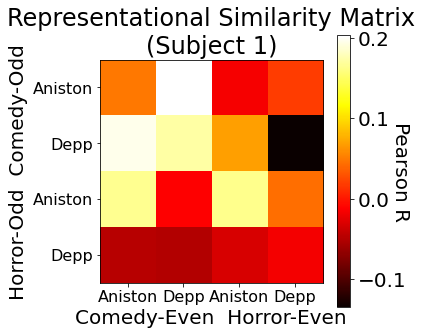

In [10]:
# Plot correlations between even- and odd-block conditions
correlation_table = []
# first row of correlation matrix:
correlation_table.append([stats.pearsonr(comedy_aniston_even,comedy_aniston_odd)[0],
                          stats.pearsonr(comedy_depp_even,comedy_aniston_odd)[0],
                          stats.pearsonr(horror_aniston_even,comedy_aniston_odd)[0],
                          stats.pearsonr(horror_depp_even,comedy_aniston_odd)[0]])
# second row of correlation matrix:
correlation_table.append([stats.pearsonr(comedy_aniston_even,comedy_depp_odd)[0],
                          stats.pearsonr(comedy_depp_even,comedy_depp_odd)[0],
                          stats.pearsonr(horror_aniston_even,comedy_depp_odd)[0],
                          stats.pearsonr(horror_depp_even,comedy_depp_odd)[0]])
# third row of correlation matrix:
correlation_table.append([stats.pearsonr(comedy_aniston_even,horror_aniston_odd)[0],
                          stats.pearsonr(comedy_depp_even,horror_aniston_odd)[0],
                          stats.pearsonr(horror_aniston_even,horror_aniston_odd)[0],
                          stats.pearsonr(horror_depp_even,horror_aniston_odd)[0]])
# fourth row of correlation matrix:
correlation_table.append([stats.pearsonr(comedy_aniston_even,horror_depp_odd)[0],
                          stats.pearsonr(comedy_depp_even,horror_depp_odd)[0],
                          stats.pearsonr(horror_aniston_even,horror_depp_odd)[0],
                          stats.pearsonr(horror_depp_even,horror_depp_odd)[0]])
# plot correlation matrix
plt.rcParams.update({'font.size': 20, 'figure.figsize': (5,5)}) # change default plotting
plt.imshow(correlation_table,cmap='hot')
plt.title("Representational Similarity Matrix\n(Subject {})".format(sub+1))
plt.yticks(np.arange(4),["Aniston","Depp","Aniston","Depp"],fontsize=16)
plt.ylabel("Horror-Odd  Comedy-Odd")
plt.xticks(np.arange(4),["Aniston","Depp","Aniston","Depp"],fontsize=16)
plt.xlabel("Comedy-Even  Horror-Even")
cbar = plt.colorbar()
cbar.set_label('Pearson R', rotation=270)
plt.show()

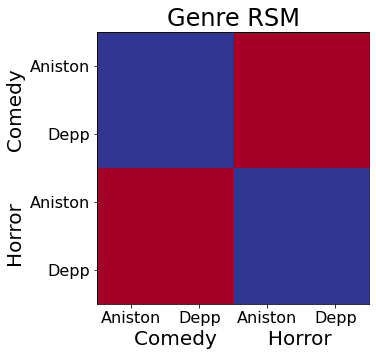

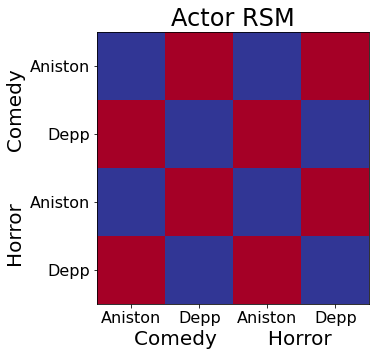

In [12]:
ComedyVsHorror= []
ComedyVsHorror.append([1,1,0,0])
ComedyVsHorror.append([1,1,0,0])
ComedyVsHorror.append([0,0,1,1])
ComedyVsHorror.append([0,0,1,1])
# plot correlation matrix
plt.rcParams.update({'font.size': 20, 'figure.figsize': (5,5)}) # change default plotting
plt.imshow(ComedyVsHorror,cmap='RdYlBu')
plt.title("Genre RSM")
plt.yticks(np.arange(4),["Aniston","Depp","Aniston","Depp"],fontsize=16)
plt.ylabel("Horror        Comedy")
plt.xticks(np.arange(4),["Aniston","Depp","Aniston","Depp"],fontsize=16)
plt.xlabel("Comedy        Horror")
plt.show()

AnistonVsDepp = []
AnistonVsDepp.append([1,0,1,0])
AnistonVsDepp.append([0,1,0,1])
AnistonVsDepp.append([1,0,1,0])
AnistonVsDepp.append([0,1,0,1])
# plot correlation matrix
plt.rcParams.update({'font.size': 20, 'figure.figsize': (5,5)}) # change default plotting
plt.imshow(AnistonVsDepp,cmap='RdYlBu')
plt.title("Actor RSM")
plt.yticks(np.arange(4),["Aniston","Depp","Aniston","Depp"],fontsize=16)
plt.ylabel("Horror        Comedy")
plt.xticks(np.arange(4),["Aniston","Depp","Aniston","Depp"],fontsize=16)
plt.xlabel("Comedy        Horror")
plt.show()

# comedy_Rs = np.array(correlation_table)[np.array(ComedyVsHorror)==1]
# horror_Rs = np.array(correlation_table)[np.array(ComedyVsHorror)==0]
# plt.bar(0,np.mean(comedy_Rs),color='blue')
# plt.bar(1,np.mean(horror_Rs),color='darkred')
# plt.scatter(0,np.mean(comedy_Rs),color='k',zorder=2)
# plt.scatter(1,np.mean(horror_Rs),color='k',zorder=2)
# plt.axhline(0,c='k')
# plt.title("Subject {}".format(sub+1))
# plt.xticks(np.arange(2),["Comedy","Horror"])
# plt.ylabel("Avg. correlation")
# plt.ylim(0,.1)
# plt.show()

# aniston_Rs = np.array(correlation_table)[np.array(AnistonVsDepp)==1]
# depp_Rs = np.array(correlation_table)[np.array(AnistonVsDepp)==0]
# plt.bar(0,np.mean(aniston_Rs),color='blue')
# plt.bar(1,np.mean(depp_Rs),color='darkred')
# plt.scatter(0,np.mean(aniston_Rs),color='k',zorder=2)
# plt.scatter(1,np.mean(depp_Rs),color='k',zorder=2)
# plt.axhline(0,c='k')
# plt.title("Subject {}".format(sub+1))
# plt.xticks(np.arange(2),["Aniston","Depp"])
# plt.ylabel("Avg. correlation")
# plt.ylim(0,.1)
# plt.show()

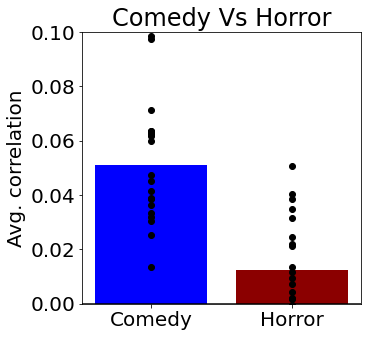


Paired t-test: t=5.5199, p=0.0000


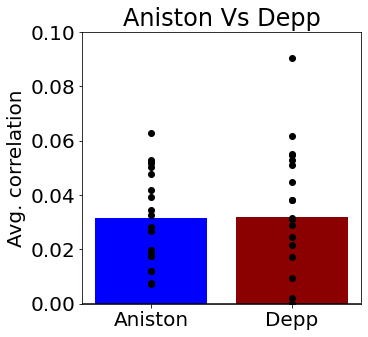


Paired t-test: t=-0.0462, p=0.9636


In [383]:
# Calcuate correlations between even- and odd-block conditions
comedy_allsub = np.full((num_subjects),np.nan)
horror_allsub = np.full((num_subjects),np.nan)
aniston_allsub = np.full((num_subjects),np.nan)
depp_allsub = np.full((num_subjects),np.nan)
for sub in range(num_subjects):
    correlation_table=[]
    comedy_aniston_even = activations[(sub_id==sub)&(cond=='comedy')&(block_id%2==0)&(actor=="Aniston")]
    comedy_aniston_odd = activations[(sub_id==sub)&(cond=='comedy')&(block_id%2==1)&(actor=="Aniston")]
    comedy_depp_even = activations[(sub_id==sub)&(cond=='comedy')&(block_id%2==0)&(actor=="Depp")]
    comedy_depp_odd = activations[(sub_id==sub)&(cond=='comedy')&(block_id%2==1)&(actor=="Depp")]
    horror_aniston_even = activations[(sub_id==sub)&(cond=='horror')&(block_id%2==0)&(actor=="Aniston")]
    horror_aniston_odd = activations[(sub_id==sub)&(cond=='horror')&(block_id%2==1)&(actor=="Aniston")]
    horror_depp_even = activations[(sub_id==sub)&(cond=='horror')&(block_id%2==0)&(actor=="Depp")]
    horror_depp_odd = activations[(sub_id==sub)&(cond=='horror')&(block_id%2==1)&(actor=="Depp")]
    # first row of correlation matrix:
    correlation_table.append([sp.stats.pearsonr(comedy_aniston_even,comedy_aniston_odd)[0],
                              sp.stats.pearsonr(comedy_depp_even,comedy_aniston_odd)[0],
                              sp.stats.pearsonr(horror_aniston_even,comedy_aniston_odd)[0],
                              sp.stats.pearsonr(horror_depp_even,comedy_aniston_odd)[0]])
    # second row of correlation matrix:
    correlation_table.append([sp.stats.pearsonr(comedy_aniston_even,comedy_depp_odd)[0],
                              sp.stats.pearsonr(comedy_depp_even,comedy_depp_odd)[0],
                              sp.stats.pearsonr(horror_aniston_even,comedy_depp_odd)[0],
                              sp.stats.pearsonr(horror_depp_even,comedy_depp_odd)[0]])
    # third row of correlation matrix:
    correlation_table.append([sp.stats.pearsonr(comedy_aniston_even,horror_aniston_odd)[0],
                              sp.stats.pearsonr(comedy_depp_even,horror_aniston_odd)[0],
                              sp.stats.pearsonr(horror_aniston_even,horror_aniston_odd)[0],
                              sp.stats.pearsonr(horror_depp_even,horror_aniston_odd)[0]])
    # fourth row of correlation matrix:
    correlation_table.append([sp.stats.pearsonr(comedy_aniston_even,horror_depp_odd)[0],
                              sp.stats.pearsonr(comedy_depp_even,horror_depp_odd)[0],
                              sp.stats.pearsonr(horror_aniston_even,horror_depp_odd)[0],
                              sp.stats.pearsonr(horror_depp_even,horror_depp_odd)[0]])
    comedy_allsub[sub] = np.mean(np.array(correlation_table)[np.array(ComedyVsHorror)==1])
    horror_allsub[sub] = np.mean(np.array(correlation_table)[np.array(ComedyVsHorror)==0])
    aniston_allsub[sub] = np.mean(np.array(correlation_table)[np.array(AnistonVsDepp)==1])
    depp_allsub[sub] = np.mean(np.array(correlation_table)[np.array(AnistonVsDepp)==0])
    
plt.bar(0,np.mean(comedy_allsub),color='blue')
plt.bar(1,np.mean(horror_allsub),color='darkred')
plt.scatter(np.zeros(num_subjects),comedy_allsub,color='k',zorder=2)
plt.scatter(np.ones(num_subjects),horror_allsub,color='k',zorder=2)
plt.axhline(0,c='k')
plt.title("Comedy Vs Horror")
plt.xticks(np.arange(2),["Comedy","Horror"])
plt.ylabel("Avg. correlation")
plt.ylim(0,.1)
plt.show()
stat = sp.stats.ttest_rel(comedy_allsub,horror_allsub)
print("\nPaired t-test: t={:.4f}, p={:.4f}".format(stat.statistic,stat.pvalue))

plt.bar(0,np.mean(aniston_allsub),color='blue')
plt.bar(1,np.mean(depp_allsub),color='darkred')
plt.scatter(np.zeros(num_subjects),aniston_allsub,color='k',zorder=2)
plt.scatter(np.ones(num_subjects),depp_allsub,color='k',zorder=2)
plt.axhline(0,c='k')
plt.title("Aniston Vs Depp")
plt.xticks(np.arange(2),["Aniston","Depp"])
plt.ylabel("Avg. correlation")
plt.ylim(0,.1)
plt.show()
stat = sp.stats.ttest_rel(aniston_allsub,depp_allsub)
print("\nPaired t-test: t={:.4f}, p={:.4f}".format(stat.statistic,stat.pvalue))